I came across the [Tensorflow time series tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series) and wanted to see if I could apply it to [project 4](./project-4-stock-predictor.ipynb) and see if a neural net makes any difference.

This notebook relies on a [Python 3.10](https://www.python.org/downloads/) environment with [these modules](requirements-tf.txt) and [the project 4 datasets](./data/README.md).

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # https://stackoverflow.com/q/40426502/3178898
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf # cuda warnings are a known bug https://github.com/tensorflow/tensorflow/issues/62075
from sklearn.model_selection import TimeSeriesSplit

First to load and preprocess the data. I'm going to normalize everything to the mean so all inputs are [-1, 1] for the neural net.

In [2]:
def load_time_series(path:str, index:str, target:str, **kwargs) -> pd.DataFrame:
    data = pd.read_csv(path, index_col=index, usecols=[index, target], **kwargs).dropna()
    data.index = pd.to_datetime(data.index, **kwargs).to_period('D')
    return data.sort_index()

btc_data = load_time_series('./data/BTC-USD.csv', 'Date', 'Close')
fng_data = load_time_series('./data/crypto-FNG.csv', 'date', 'fng_value', dayfirst=True)
data = pd.concat([btc_data, fng_data], axis=1, join='inner').set_axis(['close', 'fng'], axis=1)
data = (data - data.mean()) / data.std() # norm
with pd.option_context('display.max_rows', 4): display(data)

,close,fng
2018-02-01,-0.730132,-0.608339
2018-02-02,-0.750958,-1.299943
...,...,...
2023-07-30,0.502121,0.406012
2023-08-01,0.504565,0.452119


The tutorial engineers several features, but the ones we're interested in are the **time features** and **lag features**. Let's start with [the former](https://www.tensorflow.org/tutorials/structured_data/time_series#time):

,close,fng,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos,week_sin,week_cos
2018-02-01,-0.730132,-0.608339,0.433884,-0.900969,0.523104,0.852269,0.566700,0.823924
2018-02-02,-0.750958,-1.299943,-0.433884,-0.900969,0.537687,0.843144,0.566700,0.823924
2018-02-03,-0.729864,-0.147271,-0.974928,-0.222521,0.552111,0.833770,0.566700,0.823924
2018-02-04,-0.784898,-0.884981,-0.781831,0.623490,0.566372,0.824150,0.566700,0.823924
2018-02-05,-0.865909,-1.484370,0.000000,1.000000,0.580465,0.814285,0.661633,0.749828
...,...,...,...,...,...,...,...,...
2023-07-27,0.498161,0.359905,0.433884,-0.900969,-0.422847,-0.906201,-0.455898,-0.890032
2023-07-28,0.504814,0.406012,-0.433884,-0.900969,-0.438373,-0.898793,-0.455898,-0.890032
2023-07-29,0.507123,0.406012,-0.974928,-0.222521,-0.453769,-0.891119,-0.455898,-0.890032
2023-07-30,0.502121,0.406012,-0.781831,0.623490,-0.469031,-0.883182,-0.455898,-0.890032


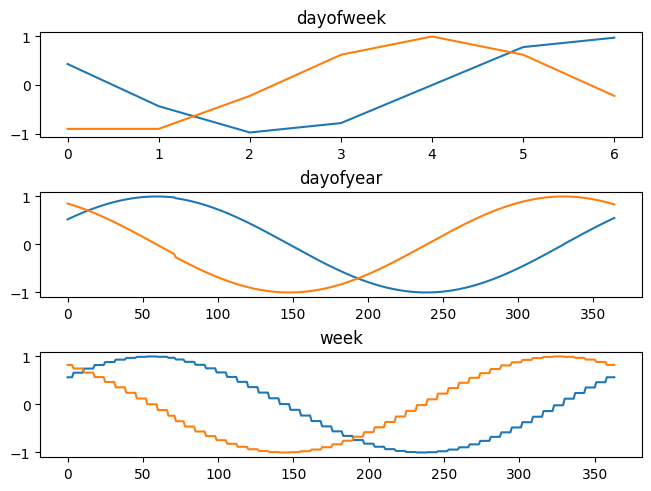

In [3]:
time_features = ['dayofweek', 'dayofyear', 'week']
data['dayofweek'] = data.index.dayofweek
data['dayofyear'] = data.index.dayofyear
data['week'] = data.index.week # data is daily so chart becomes stepped

fig, axs = plt.subplots(3, 1, constrained_layout=True) # https://stackoverflow.com/a/51657238/3178898
for i, (feature, period) in enumerate(zip(time_features, [7, 365.2425, 52.143])):
    feature_sin = f'{feature}_sin'
    feature_cos = f'{feature}_cos'
    temp = data.pop(feature)
    data[feature_sin] = np.sin(temp * (2 * np.pi / period))
    data[feature_cos] = np.cos(temp * (2 * np.pi / period))
    display_period = int(period) * 7 if feature == 'week' else int(period)
    axs[i].plot(np.array(data[feature_sin])[:display_period])
    axs[i].plot(np.array(data[feature_cos])[:display_period])
    axs[i].set_title(f'{feature}')
    del temp

data

These are the last features being engineered, so I'll split off 2023 as test data for the next step.

In [4]:
test = data['2023-01-01':]
test

,close,fng,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos,week_sin,week_cos
2023-01-01,-0.273231,-0.792767,-0.781831,0.623490,0.017202,0.999852,-0.017231,0.999852
2023-01-02,-0.269346,-0.746660,0.000000,1.000000,0.034399,0.999408,0.120208,0.992749
2023-01-03,-0.269874,-0.792767,0.781831,0.623490,0.051585,0.998669,0.120208,0.992749
2023-01-04,-0.258634,-0.654446,0.974928,-0.222521,0.068757,0.997633,0.120208,0.992749
2023-01-05,-0.260258,-0.654446,0.433884,-0.900969,0.085908,0.996303,0.120208,0.992749
...,...,...,...,...,...,...,...,...
2023-07-27,0.498161,0.359905,0.433884,-0.900969,-0.422847,-0.906201,-0.455898,-0.890032
2023-07-28,0.504814,0.406012,-0.433884,-0.900969,-0.438373,-0.898793,-0.455898,-0.890032
2023-07-29,0.507123,0.406012,-0.974928,-0.222521,-0.453769,-0.891119,-0.455898,-0.890032
2023-07-30,0.502121,0.406012,-0.781831,0.623490,-0.469031,-0.883182,-0.455898,-0.890032


In [5]:
data = data[:'2022-12-31']
data

,close,fng,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos,week_sin,week_cos
2018-02-01,-0.730132,-0.608339,0.433884,-0.900969,0.523104,0.852269,0.566700,0.823924
2018-02-02,-0.750958,-1.299943,-0.433884,-0.900969,0.537687,0.843144,0.566700,0.823924
2018-02-03,-0.729864,-0.147271,-0.974928,-0.222521,0.552111,0.833770,0.566700,0.823924
2018-02-04,-0.784898,-0.884981,-0.781831,0.623490,0.566372,0.824150,0.566700,0.823924
2018-02-05,-0.865909,-1.484370,0.000000,1.000000,0.580465,0.814285,0.661633,0.749828
...,...,...,...,...,...,...,...,...
2022-12-27,-0.267587,-0.746660,0.781831,0.623490,-0.072918,0.997338,-0.017231,0.999852
2022-12-28,-0.277675,-0.700553,0.974928,-0.222521,-0.055751,0.998445,-0.017231,0.999852
2022-12-29,-0.272173,-0.700553,0.433884,-0.900969,-0.038568,0.999256,-0.017231,0.999852
2022-12-30,-0.274610,-0.700553,-0.433884,-0.900969,-0.021373,0.999772,-0.017231,0.999852


Instead of engineering lag features, the tutorial uses [data windowing](https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing) to make the model look back at earlier data while training.

In [6]:
# The idea as I understand it is to create a sliding window of inputs and predictions along a 1D tensor
# This allows past time periods to be used as an inherent part of the process (vs engineering lag features).
class WindowGenerator:
    def __init__(self, input_width:int, label_width:int, data_:pd.DataFrame, test_data:pd.DataFrame, train_index:pd.Index, valid_index:pd.Index, label_columns:list[str], shift:int=1) -> None:
        self._train_data = data_.iloc[train_index, :]
        self._valid_data = data_.iloc[valid_index, :]
        self._test_data = test_data.copy()
        self.column_indices = {name: i for i, name in enumerate(data_.columns)}
        self.label_columns = label_columns
        self.label_column_indices = {name: i for i, name in enumerate(label_columns)}
        self.input_width = input_width
        self.label_width = label_width
        self.window_size = input_width + shift
        indices = np.arange(self.window_size)
        self.input_slice = slice(0, input_width)
        self.input_indices = indices[self.input_slice]
        self.label_slice = slice(self.window_size-label_width, None)
        self.label_indices = indices[self.label_slice]
        del indices

    def __repr__(self) -> str:
        return '\n'.join([
            f'Window size: {self.window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column(s): {self.label_columns}',
        ])

    # splits the tensor `features` into input and label slices for training
    def split_window(self, features:tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.label_slice, :] # [batch, time, features]
        labels = tf.stack([labels[:, :, self.column_indices[col]] for col in self.label_columns], axis=-1)
        labels.set_shape([None, self.label_width, None])
        inputs.set_shape([None, self.input_width, None])
        return inputs, labels
    
    # converts a dataframe into a feature tensor
    def make_dataset(self, df:pd.DataFrame) -> tf.data.Dataset:
        df = np.array(df, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(data=df, targets=None, sequence_length=self.window_size,
                                                          sequence_stride=1, shuffle=True, batch_size=32)
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train_data(self) -> tf.data.Dataset:
        return self.make_dataset(self._train_data)
    
    @property
    def valid_data(self) -> tf.data.Dataset:
        return self.make_dataset(self._valid_data)
    
    @property
    def test_data(self) -> tf.data.Dataset:
        return self.make_dataset(self._test_data)
    
    @property
    def example(self) -> tuple[tf.Tensor, tf.Tensor]:
        result = getattr(self, '_example', None) # check cache
        if result is None:                       # if empty,
            result = next(iter(self.train_data)) # ...generate example
            self._example = result               # ...and cache it
        return result

In [7]:
tf.keras.utils.disable_interactive_logging() # https://stackoverflow.com/a/76863355/3178898
tf.keras.utils.set_random_seed(379)
nn = tf.keras.Sequential
layers = tf.keras.layers

class Baseline(tf.keras.Model): # https://www.tensorflow.org/tutorials/structured_data/time_series#baseline
    def __init__(self, label_index:int=None) -> None:
        super().__init__()
        self.label_index = label_index
    def call(self, inputs:tf.Tensor) -> tf.Tensor:
        if self.label_index is None: return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]
    
class ResidualWrapper(tf.keras.Model): # https://www.tensorflow.org/tutorials/structured_data/time_series#advanced_residual_connections
    def __init__(self, model:tf.keras.Model) -> None:
        super().__init__()
        self.model = model
    def call(self, inputs:tf.Tensor, *args, **kwargs) -> tf.Tensor:
        delta = self.model(inputs, *args, **kwargs)
        return inputs + delta # prediction is targeting prior value + change over t

def compile_model(model:tf.keras.Model, patience:int=2) -> dict: # originally `compile_and_fit`...
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return dict(callbacks=[early_stop]) # ...but instead of calling `model.fit()`, returns kwargs for it instead

def evaluate_models(data_:pd.DataFrame, test_data:pd.DataFrame, plot:bool=True, plot_title:str=None) -> tuple[dict, dict]:
    models = dict[str, tf.keras.Model](
        baseline = Baseline(),
        linear = nn([layers.Dense(1)]),
        dense = nn([
            layers.Dense(64, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ]),
        dense_multi = nn([ # https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_dense
            layers.Flatten(), # shape: (time, features) => (time * features, )
            layers.Dense(32, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(1),
            layers.Reshape([1, -1]) # shape: (outputs, ) => (1, outputs)
        ]),
        conv = nn([ # https://www.tensorflow.org/tutorials/structured_data/time_series#convolution_neural_network
            layers.Conv1D(32, kernel_size=(5,), activation='relu'), # kernel_size must match window's input_width
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ]),
        lstm = nn([ # https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network
            layers.LSTM(32, return_sequences=True),
            layers.Dense(1)
        ]),
        residual = ResidualWrapper(nn([
            layers.LSTM(32, return_sequences=True),
            layers.Dense(len(data_.columns), kernel_initializer=tf.initializers.zeros())
        ]))
    )
    fit_kw = {k: compile_model(models[k]) for k in models}
    val_perf = {}
    test_perf = {}
    for i, (train_index, valid_index) in enumerate(TimeSeriesSplit().split(data_)):
        data_args = dict(data_=data_, train_index=train_index, valid_index=valid_index, test_data=test_data, label_columns=['close'])
        win_step = WindowGenerator(input_width=1,  label_width=1, **data_args)  #  1-day lookback
        win_conv = WindowGenerator(input_width=5,  label_width=1, **data_args)  #  5-day lookback
        win_wide = WindowGenerator(input_width=30, label_width=1, **data_args)  # 30-day lookback
        def evaluate_model(model_keys:list[str], window:WindowGenerator) -> None:
            for k in model_keys:
                models[k].fit(window.train_data, validation_data=window.valid_data, epochs=20, **fit_kw[k])
                val_perf[k] = models[k].evaluate(window.valid_data)
                test_perf[k] = models[k].evaluate(window.test_data) # returns [mean squared error, mean absolute error]
        evaluate_model(['baseline', 'linear', 'dense'], win_step)
        evaluate_model(['dense_multi', 'conv'], win_conv)
        evaluate_model(['lstm', 'residual'], win_wide)
    if plot:
        if plot_title: plt.title(plot_title)
        xticks = np.arange(len(models))
        width = 0.3
        offset = 0.17
        plt.bar(xticks-offset, [v[1] for v in val_perf.values()], width, color='C2', label='Validation')
        plt.bar(xticks+offset, [v[1] for v in test_perf.values()], width, color='b', label='Test')
        plt.xticks(xticks, models.keys(), rotation=45)
        plt.ylabel('Prediction MAE [close, normed]')
        plt.legend()
    return val_perf, test_perf

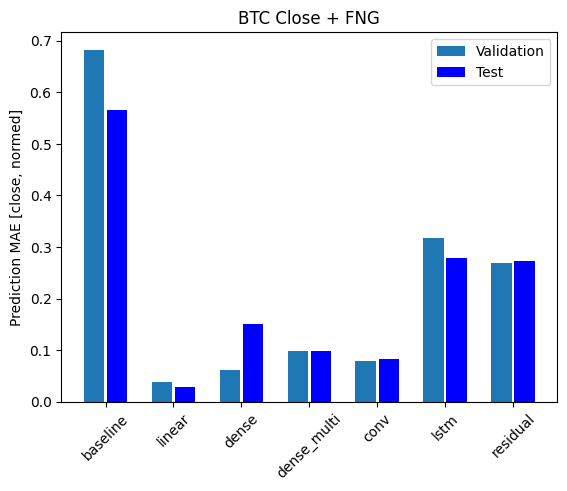

In [8]:
_, perf = evaluate_models(data, test, plot_title='BTC Close + FNG')

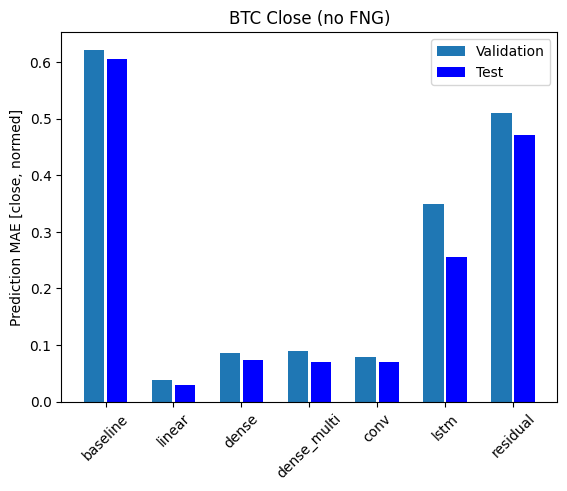

In [9]:
_, perf_no_fng = evaluate_models(data.drop('fng', axis=1), test.drop('fng', axis=1), plot_title='BTC Close (no FNG)')

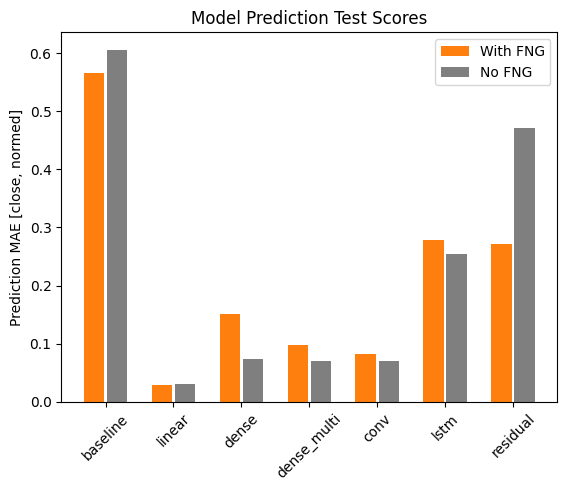

In [15]:
plt.title('Model Prediction MAE Scores')
xticks = np.arange(len(perf.keys()))
width = 0.3
offset = 0.17
plt.bar(xticks-offset, [v[1] for v in perf.values()], width, label='With FNG', color='C1')
plt.bar(xticks+offset, [v[1] for v in perf_no_fng.values()], width, label='No FNG', color='C7')
plt.xticks(xticks, perf.keys(), rotation=45)
plt.ylabel('Prediction MAE [close, normed]')
plt.legend()
pass

In [30]:
scores = [pd.DataFrame(p) for p in [perf, perf_no_fng]]
scores = pd.concat(scores).set_axis(['MSE_with_fng', 'MAE_with_fng', 'MSE_no_fng', 'MAE_no_fng'])
with pd.option_context('display.float_format', '{:,.2e}'.format): display(scores)

,baseline,linear,dense,dense_multi,conv,lstm,residual
MSE_with_fng,5.14e-01,1.46e-03,3.19e-02,1.36e-02,1.06e-02,1.18e-01,1.22e-01
MAE_with_fng,5.65e-01,2.90e-02,1.51e-01,9.78e-02,8.24e-02,2.79e-01,2.72e-01
MSE_no_fng,5.70e-01,1.76e-03,7.57e-03,8.55e-03,7.20e-03,1.20e-01,3.18e-01
MAE_no_fng,6.06e-01,3.02e-02,7.41e-02,7.00e-02,6.93e-02,2.55e-01,4.71e-01


Seems like a mixed bag -- for the most part including FNG data hurt scores, except for the baseline and residual LSTM model (which nearly cut its error score in half).

It may be that more complex models can benefit from the FNG data, but since this mostly confirms prior results (and beats them by orders of magnitude), I'm happy to call that a win and move on.